Accesible en: https://colab.research.google.com/drive/1BGsX2zXsVsgn1ub3lVGurUt-NGKRQ5XE?usp=sharing

# Búsqueda informada (heurística)

En esta clase resolveremos un problema claśico, el 8-puzzle, utilizando el algoritmo A*.



# A* (A star)

El algoritmo A* es uno de los mas famosos algoritmos de búsqueda, y basa su funcionamiento en la utilización de una función heurística. 

El algoritmo A* es un algoritmo de búsqueda, y guia la búsqueda seleccionando para expansion utilizando la siguiente función de evaluación: 

$$f(n) = g(n) + h(n)$$

donde:
- $g(n)$ es la distancia ya recorrida (o costo) para llegar desde el estado inicial $n_{start}$ al estado $n$ 
- $h(n)$ es la evaluación heurística para ese estado.

El algoritmo A* selecciona para expansión primero aquel estado con menor f(n).

El siguiente es el pseudocódigo del algoritmo A\*. Observe que la estructura del procedimiento A* es identica a la de otros algoritmos conocidos. La única diferencia es que $OPEN$ ahora es implementada como cola de prioridad

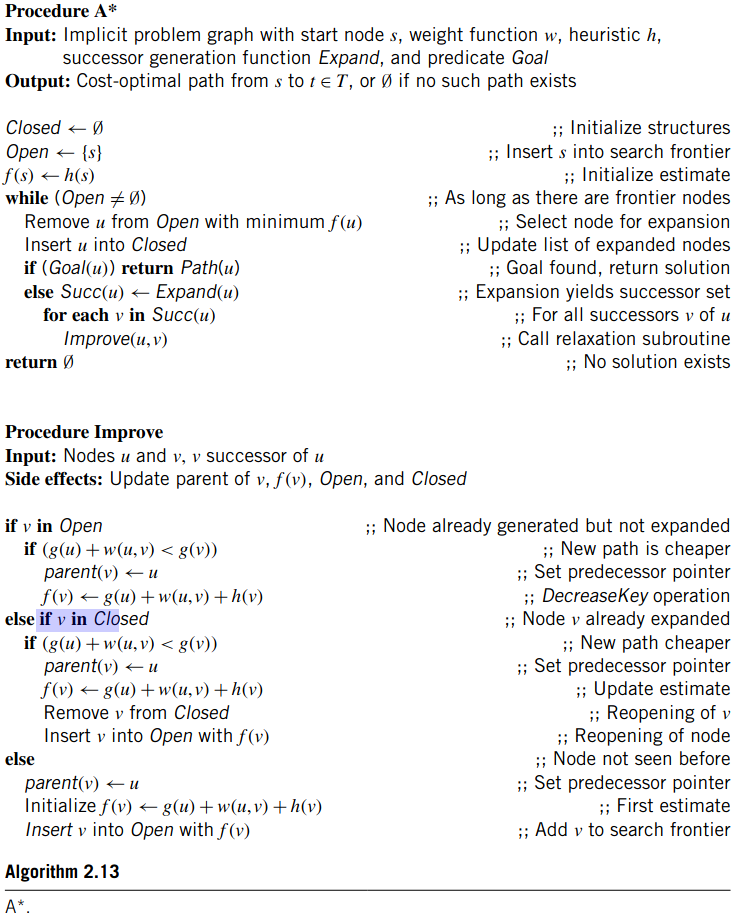

## Heuristica

Una heurística es una función que nos ayuda a guiar la búsqueda. Esta función, dado un estado $u$, retorna **una estimación de la distancia restante (costo) para llegar al estado objetivo**. 

Las heurísticas se construyen basándose en relajaciones del problema original. 

La clase `Node` representa un search state genérico, que será útil para cualquier problema de búsqueda. 

Cada uno de los estados de búsqueda, tendrá asociado un puntaje almacenado en la propiedad `key`, el cual nos indicará cuando un nodo es mejor (o solo mas prometedor) que otro. En este caso, a menor `key`, mas prometedor es el nodo. 

Tendrá los métodos __gt__ y __lt__ implementan los operadores mayor y menor que, y verifican que si nodo `v` es menor que un nodo `u`, el nodo `v` es mejor.

In [2]:
class Node:
    def __init__(self, search_state, parent=None, action=''):
        self.state = search_state # El estado (en este caso, objeto de tipo puzzle)
        self.parent = parent      # El estado padre.
        self.action = action      # El nombre de la accion que derivó en este estado (string)
        self.key = -1           # es el criterio de ordenamiento del nodo
        self.g = 0              # corresponde al costo del camino
        
    def __repr__(self):
        return self.state.__repr__()
    
    def __gt__(self, other):
        if self.key > other.key:
            return True
        else :
            return False

    def __lt__(self, other):
        if self.key < other.key:
            return True
        else :
            return False

    # Función utilizada para reconstruir la solución. Llama al método trace del estado padre hasta que no exista padre.
    def trace(self): 
        s = ''
        if self.parent:
            s = self.parent.trace()
            s += '-' + self.action + '->'
        s += str(self.state)
        return s

#clase Puzzle

Esta representa un estado del problema. La función mas importante es el método `succ`, que se encarga de la generación de estados sucesores.

In [15]:
import sys
import copy
import numpy as np


class Puzzle:
    goal8 = list(range(9))
    def __init__(self, board=None, blank=-1):
        if not board:
            self.x = 3
            self.size = 9
            self.board = [i for i in range(0, self.size)]
            self.blank = 0
        else:
            self.board = board
            if len(self.board) == 9:
                self.x = 3
                self.size = 9
            else:
                print('puzzle size not supported')
                sys.exit(1)
            if blank == -1:
                self.blank = board.index(0)


    def __hash__(self):
        return hash(tuple(self.board))

    def __eq__(self, other):
        return self.board == other.board

    def __repr__(self):
        def tostr(d):
            if d > 0:
                return "%2d" % (d)
            else:
                return "  "
        s = '\n'
        for i in range(0, self.x):
            s += "|"
            s += "|".join([tostr(d) for d in self.board[i*self.x:i*self.x+self.x]])
            s += "|\n"
        return s

    def successors(self):
        '''
            Crea una lista de tuplas de la forma (estado, accion, costo)
            donde estado es el estado sucesor de self que se genera al ejecutar
            accion (un string) y costo (un numero real) es el costo de accion
        '''
        def create_child(newblank):
            child = copy.deepcopy(self)
            child.blank = newblank
            child.board[child.blank] = 0
            child.board[self.blank] = self.board[newblank]
            return child

        succ = []
        if self.blank > self.x - 1:
            c = create_child(self.blank-self.x)
            succ.append((c, 'down', 1))
        if self.blank % self.x > 0:
            c = create_child(self.blank-1)
            succ.append((c, 'right', 1))
        if self.blank % self.x < self.x - 1:
            c = create_child(self.blank+1)
            succ.append((c, 'left', 1))
        if self.blank < self.size - self.x:
            c = create_child(self.blank+self.x)
            succ.append((c, 'up', 1))
        return succ

    def is_goal(self):
        return Puzzle.goal8 == self.board 
    
    
    def incorrect_tiles(self):
      """
      heuristica que retorna la cantidad de bloques que están en la posición incorrecta
      """
      value = 0
      for i in range(0, self.size):
        if self.board[i] != i and self.board[i] != 0:
          value += 1
      return value

    def manhattan(self):
      """
      heuristica que retorna la distancia de manhattan de cada pieza a su posición final. 
      distance = |x2 - x1| + |y2 - y1|
      """
      manDict = 0
      for i,item in enumerate(self.board):
          prev_row,prev_col = int(i/ 3) , i % 3
          goal_row,goal_col = int(item /3),item % 3
          manDict += abs(prev_row-goal_row) + abs(prev_col - goal_col)
      return manDict


    def zero_heuristic(self):
      # es una función heuristica que dado cualquier estado retorna 0
      return 0

# Open List
Esta open list, a diferencia de busqueda en anchura donde estaba implementada como una cola (deque), la implementamos como una cola de prioridad utilizando un heap. Lo importante es extraer siempre aquel nodo con menor key. Como el algoritmo es A*, definimos la key de un nodo igual a $f(n) = g(n) + h(n)$

In [4]:
import heapq

class OpenList:
    # Inicia una lista vacia
    def __init__(self):
        self.items = []

    # La cantidad de elementos en el heap
    @staticmethod
    def size(self):
        return len(self.items)

    # Retorna el mejor elemento del heap
    def top(self):
        if self.size == 0:
            return None
        else:
            return self.items[0]
    # Retorna el mejor elemento del heap y lo elimina
    def extract(self):
        if len(self.items):
            return heapq.heappop(self.items)
        else : 
            None

    # Inserta un elemento en el heap
    def insert(self, element):
        heapq.heappush(self.items, element)

    # Verifica si esta vacia
    def is_empty(self):
        return self.size == 0

In [5]:
import time

class Astar:
    def __init__(self, initial_state, heuristic):
        self.expansions = 0
        self.initial_state = initial_state
        self.solution = None
        self.heuristic = heuristic
        self.open = OpenList()
        self.generated = {}



    def search(self):
        self.start_time = time.process_time()
        
        initial_node = Node(self.initial_state)
        initial_node.g = 0
        initial_node.h = self.heuristic(self.initial_state)
        initial_node.key = initial_node.g + initial_node.h
        self.open.insert(initial_node)      
        self.generated[self.initial_state] = initial_node # para cada estado alguna vez generado, generated almacena el Node object que le corresponde

        while not self.open.is_empty():           # Mientras la OPEN no esté vacia  (ciclo de expansiones) 
            n = self.open.extract()               # extrae n de la open (el primero en ser generado)

            if n.state.is_goal():                 # Si el estado extraido es el estado objetivo (el problema resuelto)
                self.end_time = time.process_time() 
                self.solution = n                 # Define el estado extraido como solución (para reconstruirlo luego)
                return n
            succ = n.state.successors()           # Genera los sucesores
            self.expansions += 1                  # Aumenta en 1 las expansiones
            for child_state, action, cost in succ:            # Por cada uno de los estados sucesores
                child_node = self.generated.get(child_state)  # Si no existe en generados retorna 0 (false)
                path_cost = n.g + cost                        # costo del camino encontrado hasta child_state
                if child_node is None or path_cost < child_node.g : # si el estado no existe en OPEN U CLOSE (generados) o lo encontramos por un mejor camino
                    if child_node is None:                    # Si es nuevo:
                      child_node = Node(child_state, n)       # Creamos el nodo
                      child_node.h = self.heuristic(child_state) 
                      self.generated[child_state] = child_node
                    child_node.action = action                # definimos el nombre de la acción del nodo
                    child_node.parent = n                     # definimos el padre
                    child_node.g = path_cost                  # aumentamos el costo del camino con el costo de la accion
                    child_node.key = child_node.g + child_node.h #efine la key como f=g+h
                    self.open.insert(child_node)              # agrega el nodo a la OPEN 
        
        self.end_time = time.process_time()  
        print("No solution found")                # Si el ciclo de expansiones termina sin encontrar solución, no existe solución.
        return None

    

# Resolviendo puzzles con A*

Resolveremos el siguiente puzzle utilizando A* con diferentes heuristicas


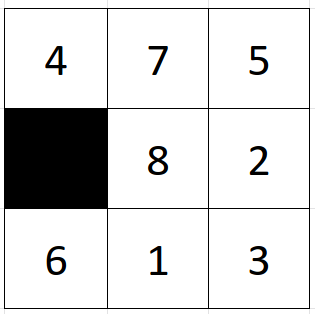

### A* utilizando la cantidad de bloques en posición incorrecta como heuristica

In [6]:
problem = Puzzle([4, 7, 5, 0, 8, 2, 6, 1, 3])

s = Astar(problem, Puzzle.incorrect_tiles) 
#s = Astar(problem, Puzzle.manhattan) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

Expansiones:      25399
Generados:      37108
Costo:         25
Tiempo:       3.23
Solucion*-***************************************

| 4| 7| 5|
|  | 8| 2|
| 6| 1| 3|
-up->
| 4| 7| 5|
| 6| 8| 2|
|  | 1| 3|
-left->
| 4| 7| 5|
| 6| 8| 2|
| 1|  | 3|
-down->
| 4| 7| 5|
| 6|  | 2|
| 1| 8| 3|
-down->
| 4|  | 5|
| 6| 7| 2|
| 1| 8| 3|
-left->
| 4| 5|  |
| 6| 7| 2|
| 1| 8| 3|
-up->
| 4| 5| 2|
| 6| 7|  |
| 1| 8| 3|
-right->
| 4| 5| 2|
| 6|  | 7|
| 1| 8| 3|
-up->
| 4| 5| 2|
| 6| 8| 7|
| 1|  | 3|
-left->
| 4| 5| 2|
| 6| 8| 7|
| 1| 3|  |
-down->
| 4| 5| 2|
| 6| 8|  |
| 1| 3| 7|
-right->
| 4| 5| 2|
| 6|  | 8|
| 1| 3| 7|
-right->
| 4| 5| 2|
|  | 6| 8|
| 1| 3| 7|
-up->
| 4| 5| 2|
| 1| 6| 8|
|  | 3| 7|
-left->
| 4| 5| 2|
| 1| 6| 8|
| 3|  | 7|
-down->
| 4| 5| 2|
| 1|  | 8|
| 3| 6| 7|
-down->
| 4|  | 2|
| 1| 5| 8|
| 3| 6| 7|
-right->
|  | 4| 2|
| 1| 5| 8|
| 3| 6| 7|
-up->
| 1| 4| 2|
|  | 5| 8|
| 3| 6| 7|
-up->
| 1| 4| 2|
| 3| 5| 8|
|  | 6| 7|
-left->
| 1| 4| 2|
| 3| 5| 8|
| 6|  | 7|
-left->
| 1| 4| 2|
| 

### A* utilizando la distancia de manhattan como heuristica

In [7]:
problem = Puzzle([4, 7, 5, 0, 8, 2, 6, 1, 3])

#s = Astar(problem, Puzzle.incorrect_tiles) 
s = Astar(problem, Puzzle.manhattan) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

Expansiones:       3129
Generados:       4805
Costo:         25
Tiempo:       0.28
Solucion*-***************************************

| 4| 7| 5|
|  | 8| 2|
| 6| 1| 3|
-down->
|  | 7| 5|
| 4| 8| 2|
| 6| 1| 3|
-left->
| 7|  | 5|
| 4| 8| 2|
| 6| 1| 3|
-left->
| 7| 5|  |
| 4| 8| 2|
| 6| 1| 3|
-up->
| 7| 5| 2|
| 4| 8|  |
| 6| 1| 3|
-right->
| 7| 5| 2|
| 4|  | 8|
| 6| 1| 3|
-down->
| 7|  | 2|
| 4| 5| 8|
| 6| 1| 3|
-right->
|  | 7| 2|
| 4| 5| 8|
| 6| 1| 3|
-up->
| 4| 7| 2|
|  | 5| 8|
| 6| 1| 3|
-up->
| 4| 7| 2|
| 6| 5| 8|
|  | 1| 3|
-left->
| 4| 7| 2|
| 6| 5| 8|
| 1|  | 3|
-left->
| 4| 7| 2|
| 6| 5| 8|
| 1| 3|  |
-down->
| 4| 7| 2|
| 6| 5|  |
| 1| 3| 8|
-right->
| 4| 7| 2|
| 6|  | 5|
| 1| 3| 8|
-right->
| 4| 7| 2|
|  | 6| 5|
| 1| 3| 8|
-up->
| 4| 7| 2|
| 1| 6| 5|
|  | 3| 8|
-left->
| 4| 7| 2|
| 1| 6| 5|
| 3|  | 8|
-down->
| 4| 7| 2|
| 1|  | 5|
| 3| 6| 8|
-down->
| 4|  | 2|
| 1| 7| 5|
| 3| 6| 8|
-right->
|  | 4| 2|
| 1| 7| 5|
| 3| 6| 8|
-up->
| 1| 4| 2|
|  | 7| 5|
| 3| 6| 8|
-up->
| 1| 4| 2|
|

In [17]:
problem = Puzzle([4, 7, 5, 0, 8, 2, 6, 1, 3])

#s = Astar(problem, Puzzle.manhattan) 
#s = Astar(problem, Puzzle.incorrect_tiles) 
s = Astar(problem, Puzzle.zero_heuristic) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

Expansiones:     154103
Generados:     168557
Costo:         25
Tiempo:      11.54
Solucion*-***************************************

| 4| 7| 5|
|  | 8| 2|
| 6| 1| 3|
-left->
| 4| 7| 5|
| 8|  | 2|
| 6| 1| 3|
-down->
| 4|  | 5|
| 8| 7| 2|
| 6| 1| 3|
-left->
| 4| 5|  |
| 8| 7| 2|
| 6| 1| 3|
-up->
| 4| 5| 2|
| 8| 7|  |
| 6| 1| 3|
-right->
| 4| 5| 2|
| 8|  | 7|
| 6| 1| 3|
-right->
| 4| 5| 2|
|  | 8| 7|
| 6| 1| 3|
-up->
| 4| 5| 2|
| 6| 8| 7|
|  | 1| 3|
-left->
| 4| 5| 2|
| 6| 8| 7|
| 1|  | 3|
-left->
| 4| 5| 2|
| 6| 8| 7|
| 1| 3|  |
-down->
| 4| 5| 2|
| 6| 8|  |
| 1| 3| 7|
-right->
| 4| 5| 2|
| 6|  | 8|
| 1| 3| 7|
-right->
| 4| 5| 2|
|  | 6| 8|
| 1| 3| 7|
-up->
| 4| 5| 2|
| 1| 6| 8|
|  | 3| 7|
-left->
| 4| 5| 2|
| 1| 6| 8|
| 3|  | 7|
-down->
| 4| 5| 2|
| 1|  | 8|
| 3| 6| 7|
-down->
| 4|  | 2|
| 1| 5| 8|
| 3| 6| 7|
-right->
|  | 4| 2|
| 1| 5| 8|
| 3| 6| 7|
-up->
| 1| 4| 2|
|  | 5| 8|
| 3| 6| 7|
-up->
| 1| 4| 2|
| 3| 5| 8|
|  | 6| 7|
-left->
| 1| 4| 2|
| 3| 5| 8|
| 6|  | 7|
-left->
| 1| 4| 2|

### OTROS PUZZLES

In [ ]:
problem = Puzzle([0, 1, 8, 7, 2, 4, 5, 6, 3])

#s = Astar(problem, Puzzle.manhattan) 
s = Astar(problem, Puzzle.incorrect_tiles) 
#s = Astar(problem, Puzzle.manhattan) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

In [ ]:
problem = Puzzle([0, 1, 8, 7, 2, 4, 5, 6, 3])

#s = Astar(problem, Puzzle.incorrect_tiles) 
s = Astar(problem, Puzzle.manhattan) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

In [ ]:
problem = Puzzle([0, 1, 8, 7, 2, 4, 5, 6, 3])

#s = Astar(problem, Puzzle.incorrect_tiles) 
s = Astar(problem, Puzzle.manhattan) 

result = s.search()
print('Expansiones: %10d' % s.expansions )
print('Generados: %10d' % len(s.generated) )
print('Costo: %10d' % result.g )
print('Tiempo: %10.2f' % (s.end_time-s.start_time) )

print("Solucion*-***************************************")
print(result.trace())

# Preguntas:
- Cual es la importancia de la heurística en la búsqueda A*?
- La solución encontrada por A* usando la heuristica de manhattan es la solución optima? ¿Por que? Demuestrelo.

R: Si es la solución optima, siempre y cuando la heuristica cumpla cierta propiedad. Admisibilidad de la heuristica. 

- Que es la admisibilidad de la heuristica? Son la distancia de manhattan, la heuristica de los bloques incorrectos, y la zero heuristic heuristicas admisibles?

- Se le ocurre alguna forma de acelerar la búsqueda (reducir las expansiones)?
